In [1]:
from tg.grammar_ru.common import Loc
from tg.grammar_ru.tasks.alternative import AlternativeTaskBundleBuilder, AlternativeTaskBundleConfig
from tg.grammar_ru.tasks.alternative import EndingNegativeSampler
from tg.grammar_ru.ml import features as fe

tsa_sampler = EndingNegativeSampler('тся','ться')


config = AlternativeTaskBundleConfig(
    [
        Loc.corpus_path/'pub.base.zip',
        Loc.corpus_path/'books.base.zip',
        Loc.corpus_path/'lenta.base.zip'
    ],
    None,
    tsa_sampler,
    [
        fe.PyMorphyFeaturizer(),
        fe.SlovnetFeaturizer(),
        fe.SyntaxTreeFeaturizer(),
        fe.SyntaxStatsFeaturizer()
        
    ],
    Loc.temp_path/'tsa/',
)

builder = AlternativeTaskBundleBuilder(config)

In [2]:
from typing import *
import pandas as pd
from tg.grammar_ru.common import *
from tg.grammar_ru.algorithms import SpellcheckAlgorithm
import numpy as np
from yo_fluq_ds import *


def _count_verbs(dfs: Iterable[pd.DataFrame]):
    counter = {}
    for df in dfs:
        df = df.loc[df.word.str.endswith('тся') | df.word.str.endswith('ться')]
        for word in df.word.str.lower():
            counter[word] = counter.get(word,0)+1
    return counter


def _another(w):
    if w.endswith('тся'):
        return w.replace('тся', 'ться')
    else:
        return w.replace('ться', 'тся')


def _get_good_words_df(words):
    for w in list(words):
        if _another(w) not in words:
            words[_another(w)] = 0

    rows = []
    for w in words:
        if w.endswith('ться'):
            rows.append((w,_another(w),words[w], words[_another(w)]))

    df = pd.DataFrame(rows, columns=['i_word','f_word','i_cnt','f_cnt'])
    df['both_found'] = df[['i_cnt','f_cnt']].min(axis=1)>0
    df = df[df.both_found]
    df['ratio'] = np.minimum(df.i_cnt/df.f_cnt, df.f_cnt/df.i_cnt)

    alg = SpellcheckAlgorithm()
    for prefix in ['i_', 'f_']:
        xdf = pd.DataFrame(dict(word=df[prefix+'word'], word_type='ru'))
        kdf = alg.run(DataBundle(src=xdf))
        df[prefix+'spell'] = ~kdf.error

    df['both_correct'] = df.i_spell & df.f_spell
    df = df.loc[df.both_correct]
    return df


def build_dictionary(dfs):
    cnt = _count_verbs(dfs)
    df = _get_good_words_df(cnt)
    good_words = set(df.i_word).union(df.f_word)
    return good_words

dict_path = Loc.data_cache_path/'tasks/tsa-dict.json'
os.makedirs(dict_path.parent, exist_ok = True)
if not os.path.isfile(dict_path):
    tsa_dict = build_dictionary(builder.get_all_frames(True))
    FileIO.write_json(list(tsa_dict), dict_path)
else:
    tsa_dict = FileIO.read_json(dict_path)

In [3]:
from tg.grammar_ru.tasks.alternative import DictionaryFilterer

builder.config.filterer = DictionaryFilterer(tsa_dict)
buckets_path = Loc.data_cache_path/'tasks/tsa_buckets.parquet'
if not os.path.isfile(buckets_path):
    buckets = builder.compute_buckets()
    buckets.to_parquet(buckets_path)
else:
    buckets= pd.read_parquet(buckets_path)

In [4]:
buckets

,corpus_id,sentence_id,log_len
0,pub.base.zip,1,4
1,pub.base.zip,4,4
2,pub.base.zip,7,3
3,pub.base.zip,25,2
4,pub.base.zip,27,3
...,...,...,...
456855,lenta.base.zip,169870935,4
456856,lenta.base.zip,169870976,4
456857,lenta.base.zip,169871029,4
456858,lenta.base.zip,169871039,4


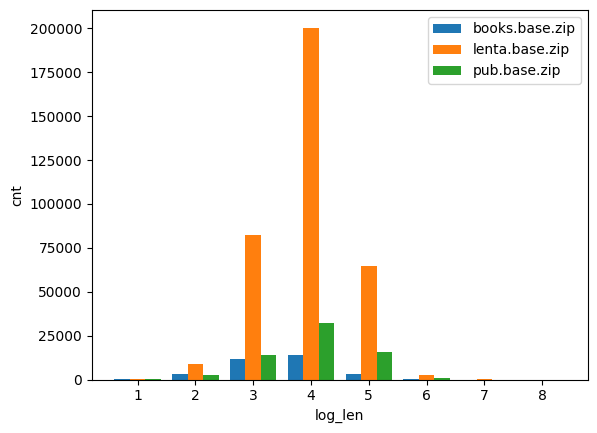

In [5]:
from tg.common.analysis import grbar_plot

ax = grbar_plot(
    buckets.groupby(['corpus_id','log_len']).size().to_frame('cnt').reset_index(),
    value_column='cnt',
    color_column='corpus_id',
    group_column='log_len'
)
ax.legend()

In [6]:
import numpy as np
df = buckets.copy()
df['random'] = np.random.rand(df.shape[0])
df = df.feed(fluq.add_ordering_column(['corpus_id', 'log_len'], 'random'))
df = df.loc[df.order<5000]
df.shape[0]

58292

In [ ]:
builder.transfuse(df)

2023-01-06 16:13:22.614880+00:00 INFO: Processed 37 words. 1/70404
2023-01-06 16:13:22.643229+00:00 INFO: Processed 37 words. 2/70404
2023-01-06 16:13:22.659428+00:00 INFO: Processed 37 words. 3/70404
2023-01-06 16:13:22.679404+00:00 INFO: Processed 37 words. 4/70404
2023-01-06 16:13:22.706744+00:00 INFO: Processed 37 words. 5/70404
2023-01-06 16:13:22.722254+00:00 INFO: Processed 37 words. 6/70404
2023-01-06 16:13:22.751182+00:00 INFO: Processed 37 words. 7/70404
2023-01-06 16:13:22.765725+00:00 INFO: Processed 37 words. 8/70404
2023-01-06 16:13:22.791039+00:00 INFO: Processed 37 words. 9/70404
2023-01-06 16:13:22.823129+00:00 INFO: Processed 37 words. 10/70404
2023-01-06 16:13:22.843031+00:00 INFO: Processed 37 words. 11/70404
2023-01-06 16:13:22.868879+00:00 INFO: Processed 37 words. 12/70404
2023-01-06 16:13:22.887150+00:00 INFO: Processed 37 words. 13/70404
2023-01-06 16:13:22.950966+00:00 INFO: Processed 177 words. 14/70404
2023-01-06 16:13:22.968060+00:00 INFO: Processed 177 wor

2023-01-06 16:13:25.121747+00:00 INFO: Processed 561 words. 120/70404
2023-01-06 16:13:25.145819+00:00 INFO: Processed 561 words. 121/70404
2023-01-06 16:13:25.162579+00:00 INFO: Processed 561 words. 122/70404
2023-01-06 16:13:25.188566+00:00 INFO: Processed 561 words. 123/70404
2023-01-06 16:13:25.251703+00:00 INFO: Processed 578 words. 124/70404
2023-01-06 16:13:25.268321+00:00 INFO: Processed 578 words. 125/70404
2023-01-06 16:13:25.283438+00:00 INFO: Processed 578 words. 126/70404
2023-01-06 16:13:25.296632+00:00 INFO: Processed 578 words. 127/70404
2023-01-06 16:13:25.320687+00:00 INFO: Processed 578 words. 128/70404
2023-01-06 16:13:25.341455+00:00 INFO: Processed 578 words. 129/70404
2023-01-06 16:13:25.363871+00:00 INFO: Processed 578 words. 130/70404
2023-01-06 16:13:25.420534+00:00 INFO: Processed 623 words. 131/70404
2023-01-06 16:13:25.441956+00:00 INFO: Processed 623 words. 132/70404
2023-01-06 16:13:25.463170+00:00 INFO: Processed 623 words. 133/70404
2023-01-06 16:13:25.

2023-01-06 16:13:28.518722+00:00 INFO: Processed 932 words. 238/70404
2023-01-06 16:13:28.533308+00:00 INFO: Processed 932 words. 239/70404
2023-01-06 16:13:28.551459+00:00 INFO: Processed 932 words. 240/70404
2023-01-06 16:13:28.569020+00:00 INFO: Processed 932 words. 241/70404
2023-01-06 16:13:28.608601+00:00 INFO: Processed 968 words. 242/70404
2023-01-06 16:13:28.619429+00:00 INFO: Processed 968 words. 243/70404
2023-01-06 16:13:28.653518+00:00 INFO: Processed 988 words. 244/70404
2023-01-06 16:13:28.666306+00:00 INFO: Processed 988 words. 245/70404
2023-01-06 16:13:28.699567+00:00 INFO: Processed 995 words. 246/70404
2023-01-06 16:13:28.715251+00:00 INFO: Processed 995 words. 247/70404
2023-01-06 16:13:28.730213+00:00 INFO: Processed 995 words. 248/70404
2023-01-06 16:13:28.750691+00:00 INFO: Processed 995 words. 249/70404
2023-01-06 16:13:28.764880+00:00 INFO: Processed 995 words. 250/70404
2023-01-06 16:13:28.777832+00:00 INFO: Processed 995 words. 251/70404
2023-01-06 16:13:28.

2023-01-06 16:13:30.977311+00:00 INFO: Processed 1760 words. 354/70404
2023-01-06 16:13:31.001761+00:00 INFO: Processed 1760 words. 355/70404
2023-01-06 16:13:31.035320+00:00 INFO: Processed 1828 words. 356/70404
2023-01-06 16:13:31.048948+00:00 INFO: Processed 1828 words. 357/70404
2023-01-06 16:13:31.064827+00:00 INFO: Processed 1828 words. 358/70404
2023-01-06 16:13:31.078699+00:00 INFO: Processed 1828 words. 359/70404
2023-01-06 16:13:31.099628+00:00 INFO: Processed 1828 words. 360/70404
2023-01-06 16:13:31.111225+00:00 INFO: Processed 1828 words. 361/70404
2023-01-06 16:13:31.127939+00:00 INFO: Processed 1828 words. 362/70404
2023-01-06 16:13:31.137663+00:00 INFO: Processed 1828 words. 363/70404
2023-01-06 16:13:31.150642+00:00 INFO: Processed 1828 words. 364/70404
2023-01-06 16:13:31.160967+00:00 INFO: Processed 1828 words. 365/70404
2023-01-06 16:13:31.170459+00:00 INFO: Processed 1828 words. 366/70404
2023-01-06 16:13:31.183626+00:00 INFO: Processed 1828 words. 367/70404
2023-0

2023-01-06 16:13:33.068530+00:00 INFO: Processed 2622 words. 470/70404
2023-01-06 16:13:33.078926+00:00 INFO: Processed 2622 words. 471/70404
2023-01-06 16:13:33.115519+00:00 INFO: Processed 2645 words. 472/70404
2023-01-06 16:13:33.129903+00:00 INFO: Processed 2645 words. 473/70404
2023-01-06 16:13:33.147970+00:00 INFO: Processed 2645 words. 474/70404
2023-01-06 16:13:33.165092+00:00 INFO: Processed 2645 words. 475/70404
2023-01-06 16:13:33.178189+00:00 INFO: Processed 2645 words. 476/70404
2023-01-06 16:13:33.188435+00:00 INFO: Processed 2645 words. 477/70404
2023-01-06 16:13:33.227207+00:00 INFO: Processed 2688 words. 478/70404
2023-01-06 16:13:33.260641+00:00 INFO: Processed 2705 words. 479/70404
2023-01-06 16:13:33.276831+00:00 INFO: Processed 2705 words. 480/70404
2023-01-06 16:13:33.286193+00:00 INFO: Processed 2705 words. 481/70404
2023-01-06 16:13:33.295863+00:00 INFO: Processed 2705 words. 482/70404
2023-01-06 16:13:33.310419+00:00 INFO: Processed 2705 words. 483/70404
2023-0

2023-01-06 16:13:35.383747+00:00 INFO: Processed 3480 words. 586/70404
2023-01-06 16:13:35.396076+00:00 INFO: Processed 3480 words. 587/70404
2023-01-06 16:13:35.446784+00:00 INFO: Processed 3495 words. 588/70404
2023-01-06 16:13:35.460675+00:00 INFO: Processed 3495 words. 589/70404
2023-01-06 16:13:35.472055+00:00 INFO: Processed 3495 words. 590/70404
2023-01-06 16:13:35.485590+00:00 INFO: Processed 3495 words. 591/70404
2023-01-06 16:13:35.497689+00:00 INFO: Processed 3495 words. 592/70404
2023-01-06 16:13:35.519641+00:00 INFO: Processed 3495 words. 593/70404
2023-01-06 16:13:35.536627+00:00 INFO: Processed 3495 words. 594/70404
2023-01-06 16:13:35.553879+00:00 INFO: Processed 3495 words. 595/70404
2023-01-06 16:13:35.574489+00:00 INFO: Processed 3495 words. 596/70404
2023-01-06 16:13:35.593830+00:00 INFO: Processed 3495 words. 597/70404
2023-01-06 16:13:35.610963+00:00 INFO: Processed 3495 words. 598/70404
2023-01-06 16:13:35.629712+00:00 INFO: Processed 3495 words. 599/70404
2023-0

2023-01-06 16:13:37.852187+00:00 INFO: Processed 4063 words. 702/70404
2023-01-06 16:13:37.867978+00:00 INFO: Processed 4063 words. 703/70404
2023-01-06 16:13:37.885362+00:00 INFO: Processed 4063 words. 704/70404
2023-01-06 16:13:37.920127+00:00 INFO: Processed 4135 words. 705/70404
2023-01-06 16:13:37.974352+00:00 INFO: Processed 4142 words. 706/70404
2023-01-06 16:13:37.991550+00:00 INFO: Processed 4142 words. 707/70404
2023-01-06 16:13:38.042921+00:00 INFO: Processed 4210 words. 708/70404
2023-01-06 16:13:38.057776+00:00 INFO: Processed 4210 words. 709/70404
2023-01-06 16:13:38.096759+00:00 INFO: Processed 4224 words. 710/70404
2023-01-06 16:13:38.112485+00:00 INFO: Processed 4224 words. 711/70404
2023-01-06 16:13:38.122983+00:00 INFO: Processed 4224 words. 712/70404
2023-01-06 16:13:38.139442+00:00 INFO: Processed 4224 words. 713/70404
2023-01-06 16:13:38.187600+00:00 INFO: Processed 4257 words. 714/70404
2023-01-06 16:13:38.201910+00:00 INFO: Processed 4257 words. 715/70404
2023-0

2023-01-06 16:13:40.534160+00:00 INFO: Processed 4870 words. 818/70404
2023-01-06 16:13:40.561606+00:00 INFO: Processed 4870 words. 819/70404
2023-01-06 16:13:40.611189+00:00 INFO: Processed 4882 words. 820/70404
2023-01-06 16:13:40.624666+00:00 INFO: Processed 4882 words. 821/70404
2023-01-06 16:13:40.640492+00:00 INFO: Processed 4882 words. 822/70404
2023-01-06 16:13:40.659549+00:00 INFO: Processed 4882 words. 823/70404
2023-01-06 16:13:40.671172+00:00 INFO: Processed 4882 words. 824/70404
2023-01-06 16:13:40.718323+00:00 INFO: Processed 4897 words. 825/70404
2023-01-06 16:13:40.735043+00:00 INFO: Processed 4897 words. 826/70404
2023-01-06 16:13:40.790254+00:00 INFO: Processed 4952 words. 827/70404
2023-01-06 16:13:40.803434+00:00 INFO: Processed 4952 words. 828/70404
2023-01-06 16:13:40.830827+00:00 INFO: Processed 4952 words. 829/70404
2023-01-06 16:13:40.849091+00:00 INFO: Processed 4952 words. 830/70404
2023-01-06 16:13:40.894169+00:00 INFO: Processed 4960 words. 831/70404
2023-0

2023-01-06 16:13:43.668445+00:00 INFO: Processed 5616 words. 934/70404
2023-01-06 16:13:43.695425+00:00 INFO: Processed 5616 words. 935/70404
2023-01-06 16:13:43.717801+00:00 INFO: Processed 5616 words. 936/70404
2023-01-06 16:13:43.757542+00:00 INFO: Processed 5616 words. 937/70404
2023-01-06 16:13:43.818733+00:00 INFO: Processed 5616 words. 938/70404
2023-01-06 16:13:43.863999+00:00 INFO: Processed 5616 words. 939/70404
2023-01-06 16:13:43.919989+00:00 INFO: Processed 5624 words. 940/70404
2023-01-06 16:13:43.945150+00:00 INFO: Processed 5624 words. 941/70404
2023-01-06 16:13:43.969068+00:00 INFO: Processed 5624 words. 942/70404
2023-01-06 16:13:43.993294+00:00 INFO: Processed 5624 words. 943/70404
2023-01-06 16:13:44.012470+00:00 INFO: Processed 5624 words. 944/70404
2023-01-06 16:13:44.034397+00:00 INFO: Processed 5624 words. 945/70404
2023-01-06 16:13:44.102014+00:00 INFO: Processed 5634 words. 946/70404
2023-01-06 16:13:44.159723+00:00 INFO: Processed 5667 words. 947/70404
2023-0